# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

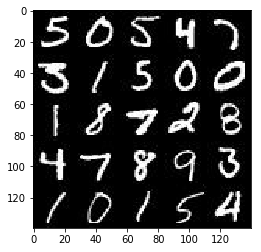

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

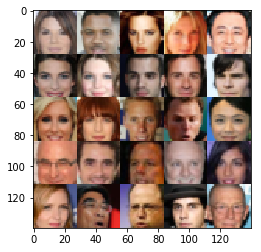

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        h1 = tf.maximum(0.2 * layer1, layer1)

        layer2 = tf.layers.conv2d(h1, 128, 5, 2, padding='same')
        b2 = tf.layers.batch_normalization(layer2, training=True)
        h2 = tf.maximum(0.2 * b2, b2)

        layer3 = tf.layers.conv2d(h2, 256, 5, 2, padding='same')
        b3 = tf.layers.batch_normalization(layer3, training=True)
        h3 = tf.maximum(0.2 * b3, b3)

        flatten_input = tf.reshape(h3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flatten_input, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, 2 * 2 * 512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(0.2 * h1, h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, padding='valid')
        b2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(b2, 0.2 * b2)

        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, padding='same')
        b3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(b3, (0.2 * b3))

        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)

    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                 logits=d_logits_real, labels=tf.ones_like(d_out_real)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_out_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator') ]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_ops = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
  
    _, image_width, image_height, image_channels = data_shape
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    
    n_images = 25
    losses = []
    show_period = 100
    print_period = 10
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                if steps % print_period == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_period == 0:
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0127... Generator Loss: 9.4379
Epoch 1/2... Discriminator Loss: 19.0660... Generator Loss: 16.6374
Epoch 1/2... Discriminator Loss: 1.6153... Generator Loss: 5.8113
Epoch 1/2... Discriminator Loss: 3.4980... Generator Loss: 11.3877
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.8105... Generator Loss: 0.3690
Epoch 1/2... Discriminator Loss: 2.3188... Generator Loss: 2.4233
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.4137
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 4.9300
Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 2.3693


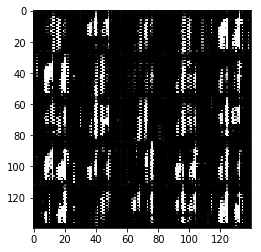

Epoch 1/2... Discriminator Loss: 2.3387... Generator Loss: 0.5555
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.5658
Epoch 1/2... Discriminator Loss: 2.2234... Generator Loss: 9.4814
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 2.3084
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 3.3451
Epoch 1/2... Discriminator Loss: 0.4676... Generator Loss: 2.2672
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5706
Epoch 1/2... Discriminator Loss: 0.4684... Generator Loss: 1.7505
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 0.9050


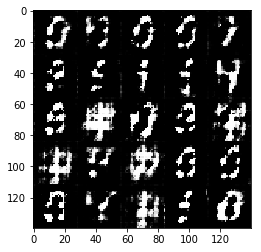

Epoch 1/2... Discriminator Loss: 1.6395... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 3.6642
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 4.6460
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 1.7318
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 2.4463
Epoch 1/2... Discriminator Loss: 0.6574... Generator Loss: 3.3670
Epoch 1/2... Discriminator Loss: 1.7968... Generator Loss: 0.3640
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.7694
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 1.6615


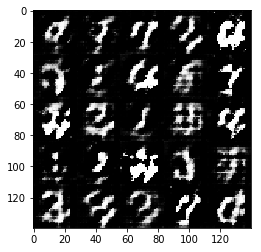

Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 2.2176
Epoch 1/2... Discriminator Loss: 1.5914... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.7458... Generator Loss: 3.3394
Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 2.1111
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 0.9264
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 2.6438
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.9074
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.3474
Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 1.7056
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 1.3250


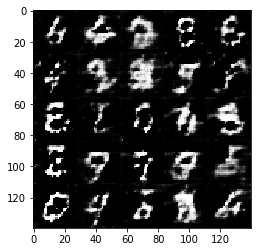

Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 1.2300
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.8196
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.5677
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 0.9713
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 2.8201
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 1.3586
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.2477
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 2.3851
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.5321


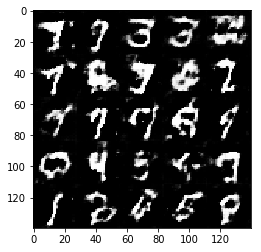

Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.7067... Generator Loss: 0.3189
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 0.7023... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.4337
Epoch 1/2... Discriminator Loss: 1.7225... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.6701... Generator Loss: 2.8037


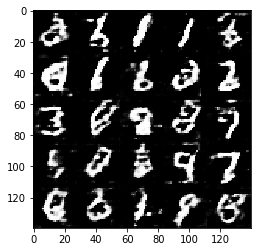

Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 1.9245
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 0.7765... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 2.0148... Generator Loss: 4.0587
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 1.6758
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 2.5583... Generator Loss: 4.0335
Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 1.2196


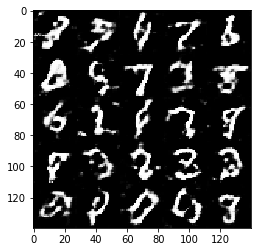

Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 0.5455... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 1.6268
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 2.1112
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.4251
Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 2.3381
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 2.5586
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 2.8466


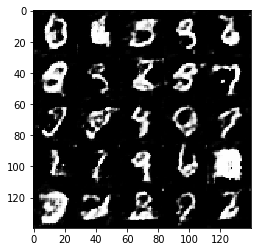

Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 2.1190
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 1.8873... Generator Loss: 0.3028
Epoch 1/2... Discriminator Loss: 0.7427... Generator Loss: 2.0518
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 1.8007... Generator Loss: 0.2833
Epoch 1/2... Discriminator Loss: 1.5536... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 0.8693


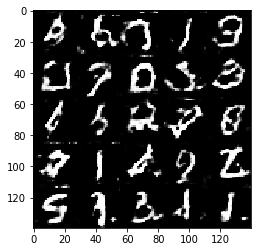

Epoch 1/2... Discriminator Loss: 1.9643... Generator Loss: 0.2562
Epoch 1/2... Discriminator Loss: 1.7761... Generator Loss: 0.2847
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 4.2616
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.1368
Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 4.3268
Epoch 2/2... Discriminator Loss: 2.6602... Generator Loss: 0.2195


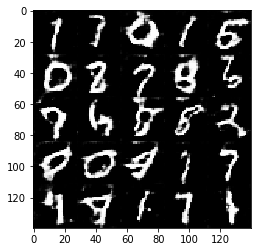

Epoch 2/2... Discriminator Loss: 1.8742... Generator Loss: 5.2162
Epoch 2/2... Discriminator Loss: 2.4337... Generator Loss: 0.1768
Epoch 2/2... Discriminator Loss: 1.8444... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 1.4894... Generator Loss: 0.4240
Epoch 2/2... Discriminator Loss: 0.5128... Generator Loss: 1.9720
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.4670
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 1.7811
Epoch 2/2... Discriminator Loss: 0.4017... Generator Loss: 2.1322
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 2.7311
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 2.8193


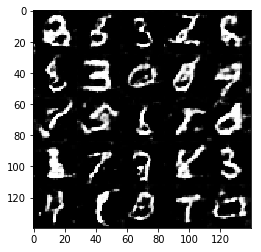

Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.6373
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.5194
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.2907
Epoch 2/2... Discriminator Loss: 2.1232... Generator Loss: 0.2079
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 2.3210... Generator Loss: 0.1990
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 0.3219... Generator Loss: 2.1073


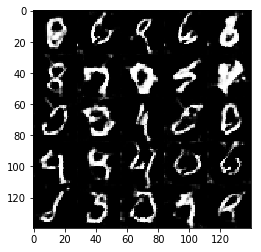

Epoch 2/2... Discriminator Loss: 1.4666... Generator Loss: 3.0971
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.9664
Epoch 2/2... Discriminator Loss: 1.7503... Generator Loss: 0.3985
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 2.5693... Generator Loss: 0.2312
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.7947
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 2.4359
Epoch 2/2... Discriminator Loss: 1.6380... Generator Loss: 0.4057
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 2.0017


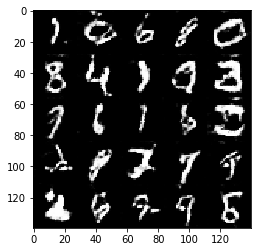

Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 2.3347
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.4279
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 0.6796... Generator Loss: 2.0148
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 2.6332
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 2.9785... Generator Loss: 0.1706
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.5137
Epoch 2/2... Discriminator Loss: 1.8815... Generator Loss: 0.3832


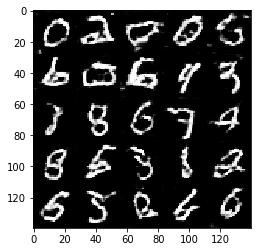

Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.4585
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.7795
Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 1.4122
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.0571
Epoch 2/2... Discriminator Loss: 0.1935... Generator Loss: 5.7004
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 0.1154... Generator Loss: 4.5026
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.1374


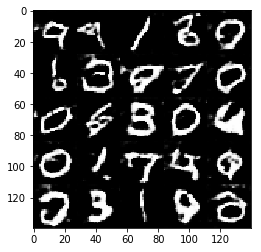

Epoch 2/2... Discriminator Loss: 0.4161... Generator Loss: 1.5786
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.5566
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 3.5809
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 4.1097
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.0758
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 2.2631
Epoch 2/2... Discriminator Loss: 2.1499... Generator Loss: 4.4572
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.5957
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.6367


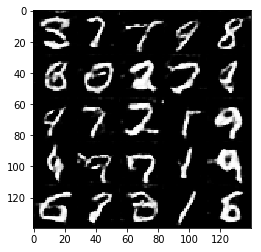

Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.5931
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.4832
Epoch 2/2... Discriminator Loss: 0.4368... Generator Loss: 2.6184
Epoch 2/2... Discriminator Loss: 0.5326... Generator Loss: 1.9064
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 5.3014
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.4600


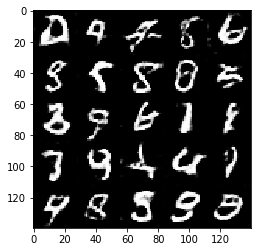

Epoch 2/2... Discriminator Loss: 1.5726... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 1.2798
Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 2.0391
Epoch 2/2... Discriminator Loss: 2.3424... Generator Loss: 5.3537
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.7735
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 2.9099
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 2.2687... Generator Loss: 0.1832
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.6387


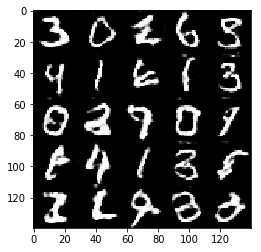

Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 1.4879
Epoch 2/2... Discriminator Loss: 0.5415... Generator Loss: 2.1871
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 0.4694... Generator Loss: 1.5843
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.5958


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2774... Generator Loss: 15.3443
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 15.2663
Epoch 1/1... Discriminator Loss: 0.2988... Generator Loss: 3.0594
Epoch 1/1... Discriminator Loss: 0.2669... Generator Loss: 7.8037
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.4201
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 0.2745... Generator Loss: 2.3353
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 3.9135


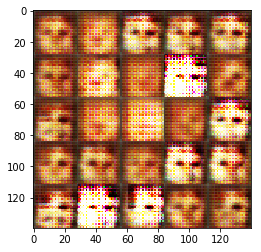

Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 2.8606
Epoch 1/1... Discriminator Loss: 0.1279... Generator Loss: 3.7400
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 4.0032
Epoch 1/1... Discriminator Loss: 3.9087... Generator Loss: 4.8872
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 0.1634... Generator Loss: 2.9407
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 4.0460
Epoch 1/1... Discriminator Loss: 0.2667... Generator Loss: 2.8878
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 1.1207
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8267


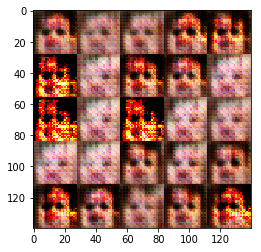

Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 4.7939
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 3.6960
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 3.0166
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 2.1686... Generator Loss: 3.4973
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.3825


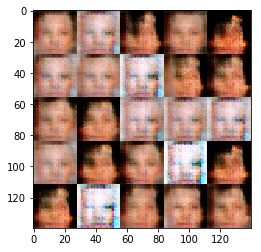

Epoch 1/1... Discriminator Loss: 2.1642... Generator Loss: 0.1332
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.8907
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 2.5280
Epoch 1/1... Discriminator Loss: 2.9312... Generator Loss: 5.3265
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 2.6126
Epoch 1/1... Discriminator Loss: 0.2101... Generator Loss: 3.0196
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 4.2337


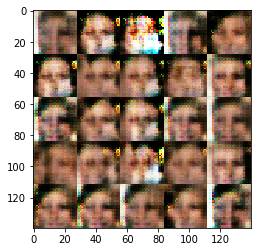

Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.8133
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 2.4716... Generator Loss: 5.2952
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 2.2416
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.6644


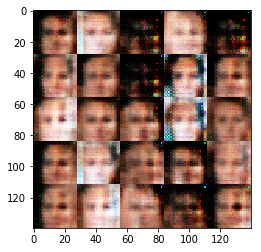

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 1.9178
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.8631... Generator Loss: 0.2679
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 2.5393
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.9601


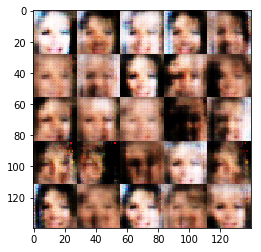

Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 2.0512... Generator Loss: 0.2139
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 2.0224


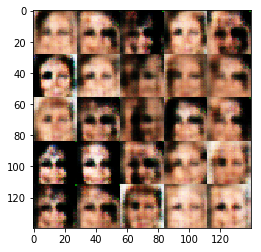

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.2314
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 2.0643
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.3077
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.5831


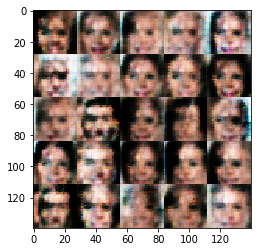

Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 2.5042... Generator Loss: 3.5153
Epoch 1/1... Discriminator Loss: 0.2692... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 0.8898


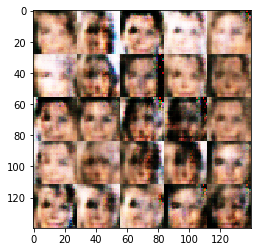

Epoch 1/1... Discriminator Loss: 1.9865... Generator Loss: 3.6475
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 2.5205
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 3.4083
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 2.7541
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 3.1532
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 2.1204
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.3653


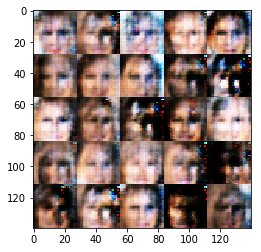

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.9861
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.9238


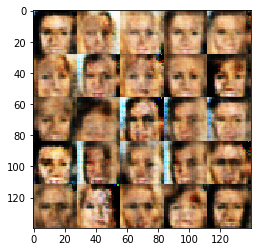

Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 3.0116
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 1.9662
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.9639
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.4850


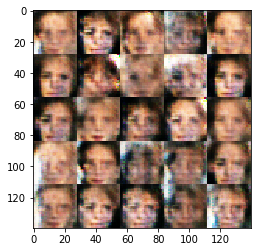

Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 2.8801... Generator Loss: 4.4959
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 2.0428
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 2.2379


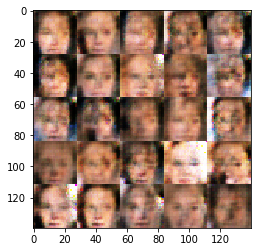

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.2893
Epoch 1/1... Discriminator Loss: 3.7040... Generator Loss: 3.6857
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 3.9599... Generator Loss: 4.9403
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 1.3650
Epoch 1/1... Discriminator Loss: 0.2450... Generator Loss: 1.7363
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.3779


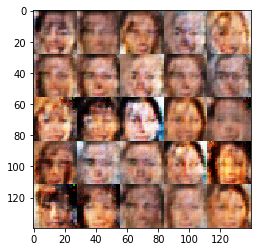

Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 2.5435
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.8885
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 0.1648... Generator Loss: 2.9275


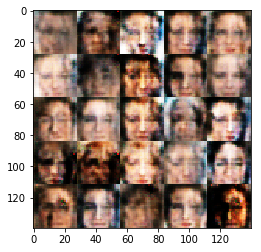

Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 1.5109
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.2667
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.9957
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 2.4086


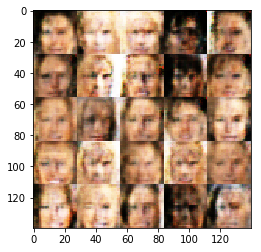

Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 2.1776
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 2.3879... Generator Loss: 2.7812


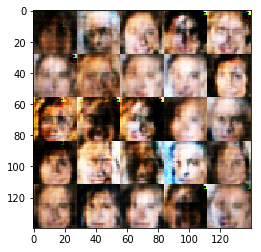

Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 1.9567
Epoch 1/1... Discriminator Loss: 2.6028... Generator Loss: 0.1831
Epoch 1/1... Discriminator Loss: 2.4163... Generator Loss: 2.4370
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 2.1151
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.8540


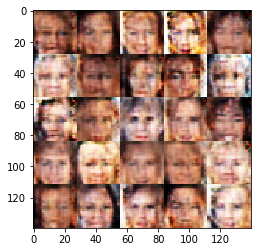

Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 1.9636
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.2211... Generator Loss: 2.4894
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.4540
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.0831


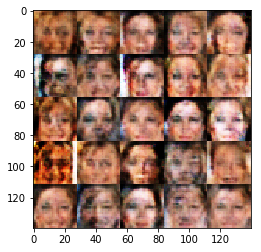

Epoch 1/1... Discriminator Loss: 2.1225... Generator Loss: 3.8393
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 1.6396
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 0.2880... Generator Loss: 2.0463
Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 2.6669
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.7871


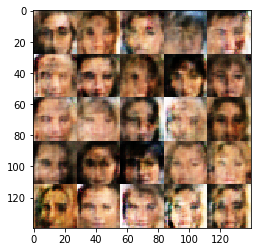

Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 2.5563
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.9580
Epoch 1/1... Discriminator Loss: 1.8890... Generator Loss: 2.1789
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.4680


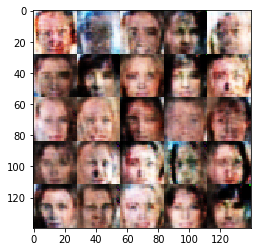

Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 2.1657
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 1.9169... Generator Loss: 0.2230
Epoch 1/1... Discriminator Loss: 2.7221... Generator Loss: 0.1053
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.6871
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.0201
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 2.5129... Generator Loss: 4.5605


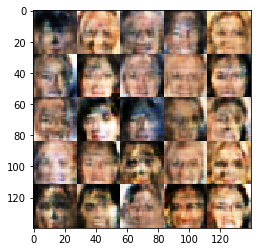

Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 1.8354... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.6897
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.4484


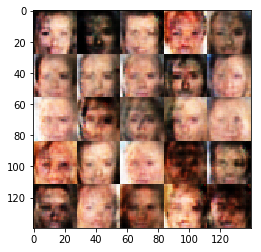

Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 2.9866
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.2799... Generator Loss: 2.1061
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.6451


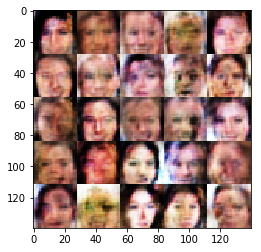

Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 2.7870
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.3805


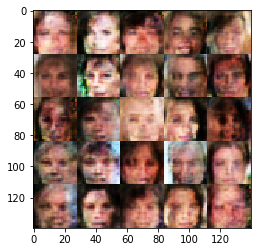

Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 2.0154
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 2.1988
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.0041
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.5159


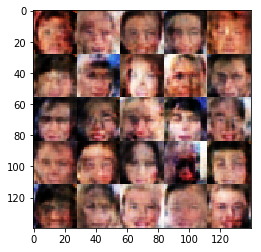

Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 2.7623
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.1076


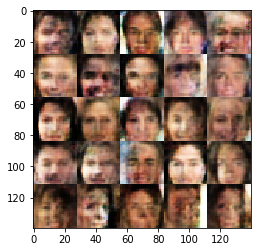

Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.5870
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 3.4473
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.5750
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 4.4536... Generator Loss: 5.7318


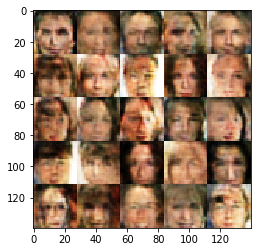

Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 2.7706
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.6802
Epoch 1/1... Discriminator Loss: 1.8736... Generator Loss: 3.0233
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.5647
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.4401


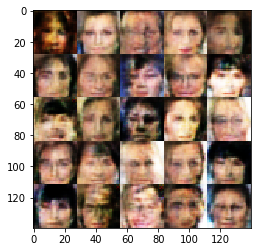

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.3630
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.7624
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 1.5971
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.3973


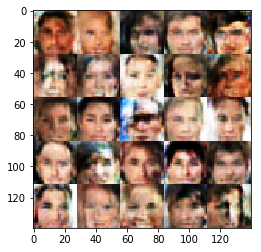

Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.7294
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 0.3157... Generator Loss: 2.9231
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8372


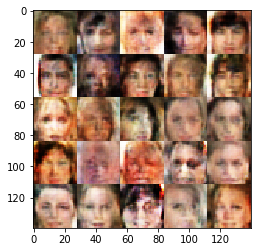

Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 2.3885
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 1.7628
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.2139


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.